In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 100
from zlib import adler32
import requests

import numpy as np
import tensorflow as tf
import inspect
np.set_printoptions(suppress=True)

In [2]:
url = 'https://raw.githubusercontent.com/adecate/Deep-Generative-models-VaR/main/Data/commodities_dataset.csv'
open('commodities_dataset.csv', 'wb').write(requests.get(url).content)
commodities = pd.read_csv('commodities_dataset.csv')


url = 'https://raw.githubusercontent.com/adecate/Deep-Generative-models-VaR/main/Data/stocks_dataset.csv'
open('stocks_dataset.csv', 'wb').write(requests.get(url).content);
stocks = pd.read_csv('stocks_dataset.csv')

In [3]:
weights = np.ones([15,1]) * 1/15

stocks['Date'] =  pd.to_datetime(stocks['Date'])
stocks['year'] = stocks['Date'].dt.year

stocks = stocks.set_index('Date')
stocks = stocks[stocks['year'] >= 2021]
stocks = stocks.drop(columns=['year'])
stocks_change =stocks.pct_change()
ret_data = stocks_change[1:].dot(weights)

mean = ret_data.apply(func=np.mean, axis=0)
std = ret_data.apply(func=np.std, axis=0)

In [4]:
commodities['Date'] =  pd.to_datetime(commodities['Date'])
commodities['year'] = commodities['Date'].dt.year

commodities = commodities.set_index('Date')
commodities = commodities[commodities['year'] >= 2021]
commodities = commodities.drop(columns=['year'])

com_returns = commodities.pct_change().dropna()
com_returns = com_returns[com_returns.index>='2021-01-01']

ret_data_com = com_returns[1:].dot(weights)

mean = ret_data_com.apply(func=np.mean, axis=0)
std = ret_data_com.apply(func=np.std, axis=0)

In [5]:
gpu_devices = tf.config.list_physical_devices(device_type="GPU")
tf.config.experimental.set_memory_growth(device=gpu_devices[0], enable=True)
tf.keras.backend.set_floatx(value="float64")
tf.config.run_functions_eagerly(run_eagerly=True)

from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import norm

import matplotlib.pyplot as plt

%matplotlib inline
from PIL import Image
import plotnine

print("TensorFlow version:", tf.__version__)
print("GPU:", gpu_devices)

In [6]:
class BidirectionalGenerativeAdversarialNetworkDiscriminator(tf.keras.Model):
    def __init__(self, num_hidden):
        super().__init__()

        args, _, _, values = inspect.getargvalues(frame=inspect.currentframe())
        values.pop("self")

        for arg, val in values.items():
            setattr(self, arg, val)

        self.concat = tf.keras.layers.Concatenate(axis=-1)
        self.feature_extractor = tf.keras.Sequential(
            layers=[
                tf.keras.layers.Dense(
                    units=self.num_hidden,
                    activation=tf.keras.layers.LeakyReLU(alpha=0.2),
                ),
            ]
        )
        self.dropout = tf.keras.layers.Dropout(rate=0.5)
        self.discriminator = tf.keras.layers.Dense(
            units=1,
            activation="sigmoid",
        )

    def call(self, x, z):
        features = self.concat([x, z])
        features = self.feature_extractor(features)
        features = self.dropout(features)

        return self.discriminator(features)

In [7]:
class BidirectionalGenerativeAdversarialNetworkGenerator(tf.keras.Model):
    def __init__(self, num_hidden, num_inputs):
        super().__init__()

        args, _, _, values = inspect.getargvalues(frame=inspect.currentframe())
        values.pop("self")

        for arg, val in values.items():
            setattr(self, arg, val)

        self.generator = tf.keras.Sequential(
            layers=[
                tf.keras.layers.Dense(
                    units=self.num_hidden,
                    activation="elu",
                ),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(
                    units=self.num_hidden,
                    activation="elu",
                ),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(
                    units=self.num_inputs,
                    activation="linear",
                ),
            ]
        )

    def call(self, z):
        return self.generator(z)

In [8]:
class BidirectionalGenerativeAdversarialNetworkEncoder(tf.keras.Model):
    def __init__(self, num_hidden, num_encoding):
        super().__init__()

        args, _, _, values = inspect.getargvalues(frame=inspect.currentframe())
        values.pop("self")

        for arg, val in values.items():
            setattr(self, arg, val)

        self.encoder = tf.keras.Sequential(
            layers=[
                tf.keras.layers.Dense(
                    units=self.num_hidden,
                    activation=tf.keras.layers.LeakyReLU(alpha=0.2),
                ),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(
                    units=self.num_hidden,
                    activation=tf.keras.layers.LeakyReLU(alpha=0.2),
                ),
                tf.keras.layers.Dense(
                    units=self.num_encoding,
                    activation="tanh",
                ),
            ]
        )

    def call(self, x):
        return self.encoder(x)

In [ ]:
@tf.function
def train_step(x, real, z, fake):
    with tf.GradientTape() as dis_tape, tf.GradientTape(
        persistent=True
    ) as enc_gen_tape:
        enc = encoder(x=x, training=True)
        gen = generator(z=z, training=True)
        disc_loss_real = reconstruction_loss(
            y_true=real,
            y_pred=discriminator(
                x=x,
                z=enc,
                training=True,
            ),
        )
        disc_loss_fake = reconstruction_loss(
            y_true=fake,
            y_pred=discriminator(
                x=gen,
                z=z,
                training=True,
            ),
        )
        disc_loss = 0.5 * (disc_loss_real + disc_loss_fake)
        enc = encoder(x=x, training=True)
        gen = generator(z=z, training=True)
        enc_loss = reconstruction_loss(
            y_true=fake,
            y_pred=discriminator(
                x=x,
                z=enc,
                training=True,
            ),
        )
        gen_loss = reconstruction_loss(
            y_true=real,
            y_pred=discriminator(
                x=gen,
                z=z,
                training=True,
            ),
        )
    gradients_disc = dis_tape.gradient(
        target=disc_loss,
        sources=discriminator.trainable_variables,
    )
    optimizer_disc.apply_gradients(
        grads_and_vars=zip(
            gradients_disc,
            discriminator.trainable_variables,
        )
    )
    disc_loss_metric(disc_loss)
    gradients_enc = enc_gen_tape.gradient(
        target=enc_loss, sources=encoder.trainable_variables
    )
    optimizer_enc_gen.apply_gradients(
        grads_and_vars=zip(
            gradients_enc,
            encoder.trainable_variables,
        )
    )
    enc_loss_metric(enc_loss)
    gradients_gen = enc_gen_tape.gradient(
        target=gen_loss, sources=generator.trainable_variables
    )
    optimizer_enc_gen.apply_gradients(
        grads_and_vars=zip(
            gradients_gen,
            generator.trainable_variables,
        )
    )
    gen_loss_metric(gen_loss)

In [ ]:
def bigan_var(ret_data):
    num_inputs = ret_data.shape[1]
    num_hidden = 100
    num_encoding = 10
    num_epochs = 10
    batch_size = 100

    generator = BidirectionalGenerativeAdversarialNetworkGenerator(
        num_hidden=num_hidden, num_inputs=num_inputs
    )
    discriminator = BidirectionalGenerativeAdversarialNetworkDiscriminator(
        num_hidden=num_hidden
    )
    encoder = BidirectionalGenerativeAdversarialNetworkEncoder(
        num_hidden=num_hidden, num_encoding=num_encoding
    )

    ds = (
        tf.data.Dataset.from_tensor_slices(tensors=ret_data)
        .shuffle(buffer_size=ret_data.shape[0] * 2, reshuffle_each_iteration=True)
        .batch(batch_size=batch_size, drop_remainder=False)
    )

    reconstruction_loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=False, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
    )
    optimizer_disc = tf.keras.optimizers.legacy.RMSprop(
        learning_rate=2e-4, decay=1e-8, clipvalue=1.0
    )
    optimizer_enc_gen = tf.keras.optimizers.legacy.RMSprop(
        learning_rate=4e-4, decay=1e-8, clipvalue=1.0
    )
    disc_loss_metric = tf.keras.metrics.Mean(name="train_disc_loss")
    enc_loss_metric = tf.keras.metrics.Mean(name="train_enc_loss")
    gen_loss_metric = tf.keras.metrics.Mean(name="train_gen_loss")


    for epoch in range(num_epochs):
        disc_loss_metric.reset_states()
        enc_loss_metric.reset_states()
        gen_loss_metric.reset_states()

        for x in ds:
            train_step(
                x=x,
                real=np.ones(shape=(x.shape[0], 1)),
                z=np.random.uniform(low=-1.0, high=1.0, size=(x.shape[0], num_encoding)),
                fake=np.zeros(shape=(x.shape[0], 1)),
            )

        if ((epoch + 1) % 100) == 0:
            print("Epoch:", epoch + 1)
            print("Discriminator loss:", disc_loss_metric.result())
            print("Encoder loss:", enc_loss_metric.result())
            print("Generator loss:", gen_loss_metric.result())


    num_sim = ret_data.shape[0]
    with tf.device(device_name="/CPU:0"):
        x_mean = [
            np.average(
                a=(
                    generator(
                        z=np.array(
                            object=[
                                np.random.uniform(low=ret_data.min(), high=ret_data.max(), size=(num_encoding))
                            ]
                        )
                    )[0]
                    #* std
                )
                #+ mean
            )
            for i in range(num_sim)
        ]

    return x_mean, generator # #act_mean, x_mean

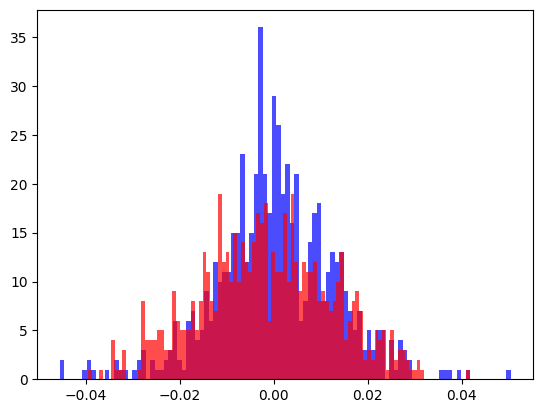

In [ ]:
gen, generator = bigan_var(ret_data)

plt.hist(ret_data[0], bins =100, color = 'blue', alpha = 0.7)
plt.hist(gen, bins =100, color = 'red', alpha = 0.7)
plt.show();

In [ ]:
def bigan_var(ret_data, generator):
    num_inputs = ret_data.shape[1]
    num_hidden = 100
    num_encoding = 10
    num_epochs = 10
    batch_size = 100

    # generator = BidirectionalGenerativeAdversarialNetworkGenerator(
    #     num_hidden=num_hidden, num_inputs=num_inputs
    # )
    discriminator = BidirectionalGenerativeAdversarialNetworkDiscriminator(
        num_hidden=num_hidden
    )
    encoder = BidirectionalGenerativeAdversarialNetworkEncoder(
        num_hidden=num_hidden, num_encoding=num_encoding
    )

    ds = (
        tf.data.Dataset.from_tensor_slices(tensors=ret_data)
        .shuffle(buffer_size=ret_data.shape[0] * 2, reshuffle_each_iteration=True)
        .batch(batch_size=batch_size, drop_remainder=False)
    )

    reconstruction_loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=False, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
    )
    optimizer_disc = tf.keras.optimizers.legacy.RMSprop(
        learning_rate=2e-4, decay=1e-8, clipvalue=1.0
    )
    optimizer_enc_gen = tf.keras.optimizers.legacy.RMSprop(
        learning_rate=4e-4, decay=1e-8, clipvalue=1.0
    )
    disc_loss_metric = tf.keras.metrics.Mean(name="train_disc_loss")
    enc_loss_metric = tf.keras.metrics.Mean(name="train_enc_loss")
    gen_loss_metric = tf.keras.metrics.Mean(name="train_gen_loss")


    # for epoch in range(num_epochs):
    #     disc_loss_metric.reset_states()
    #     enc_loss_metric.reset_states()
    #     gen_loss_metric.reset_states()

    #     for x in ds:
    #         train_step(
    #             x=x,
    #             real=np.ones(shape=(x.shape[0], 1)),
    #             z=np.random.uniform(low=-1.0, high=1.0, size=(x.shape[0], num_encoding)),
    #             fake=np.zeros(shape=(x.shape[0], 1)),
    #         )

    #     if ((epoch + 1) % 100) == 0:
    #         print("Epoch:", epoch + 1)
    #         print("Discriminator loss:", disc_loss_metric.result())
    #         print("Encoder loss:", enc_loss_metric.result())
    #         print("Generator loss:", gen_loss_metric.result())


    num_sim = ret_data.shape[0]
    with tf.device(device_name="/CPU:0"):
        x_mean = [
            np.average(
                a=(
                    generator(
                        z=np.array(
                            object=[
                                np.random.uniform(low=ret_data.min()-0.01, high=ret_data.max()+0.01, size=(num_encoding))
                            ]
                        )
                    )[0]
                    #* std
                )
                #+ mean
            )
            for i in range(num_sim)
        ]

    return  np.percentile(a=x_mean, axis=0, q=1)

In [ ]:
w = 200

i = w
portf = ret_data.copy()
var_values = pd.DataFrame({'Date': [], 'VaR': []})
breakdowns  = pd.DataFrame({'Date': [], 'value': []})

while i <=ret_data.shape[0] - 1:
  print(i)
  var_values = pd.concat([var_values, pd.DataFrame({'Date': [portf[i:i+1].index.date[0]], 'VaR': [bigan_var(portf[i-w:i], generator)]})])
  i+=1

# var_values.to_csv('bigan_vals.csv')
# files.download('bigan_vals.csv')

579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612


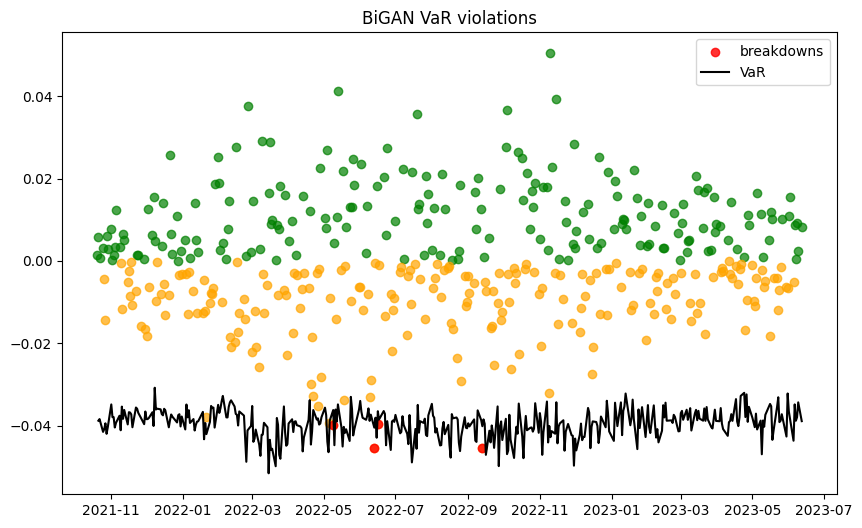

In [ ]:
portf= ret_data[200:]
fig, ax = plt.subplots(figsize=(10, 6))
pos = portf[portf.apply(lambda x: x >= 0)]
neg = portf[portf.apply(lambda x: x <  0)]

var_values['Date'] = pd.to_datetime(var_values['Date'])
var_df = var_values.merge(portf.reset_index(), on='Date')
var_df.columns = ['Date', 'VaR', 'Change']
var_df['VaR'] = var_df['VaR']- 0.006
var_df['Violation'] = (var_df['Change'] < var_df['VaR'])
breakdowns = var_df[var_df['Violation'] == 1]

#breakdowns['VaR'] = breakdowns['VaR']- 0.005
#breakdowns = breakdowns[breakdowns['Change'] < breakdowns['VaR']]

plt.scatter(pos.index,pos, c = 'green', alpha = 0.7)
plt.scatter(neg.index,neg, c = 'orange', alpha = 0.7)
plt.scatter(breakdowns.Date, breakdowns.Change, c = 'red', alpha = 0.8,  label = 'breakdowns')
plt.plot(var_df.Date, var_df.VaR, label = 'VaR', c = 'black')
plt.legend()
plt.title("{} VaR violations".format('BiGAN'))
plt.show();

In [ ]:
tests(var_df)

0.01
0.78


In [ ]:
def bigan_var(ret_data):
    num_inputs = ret_data.shape[1]
    num_hidden = 100
    num_encoding = 10
    num_epochs = 10
    batch_size = 100

    generator = BidirectionalGenerativeAdversarialNetworkGenerator(
        num_hidden=num_hidden, num_inputs=num_inputs
    )
    discriminator = BidirectionalGenerativeAdversarialNetworkDiscriminator(
        num_hidden=num_hidden
    )
    encoder = BidirectionalGenerativeAdversarialNetworkEncoder(
        num_hidden=num_hidden, num_encoding=num_encoding
    )

    ds = (
        tf.data.Dataset.from_tensor_slices(tensors=ret_data)
        .shuffle(buffer_size=ret_data.shape[0] * 2, reshuffle_each_iteration=True)
        .batch(batch_size=batch_size, drop_remainder=False)
    )

    reconstruction_loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=False, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
    )
    optimizer_disc = tf.keras.optimizers.legacy.RMSprop(
        learning_rate=2e-4, decay=1e-8, clipvalue=1.0
    )
    optimizer_enc_gen = tf.keras.optimizers.legacy.RMSprop(
        learning_rate=4e-4, decay=1e-8, clipvalue=1.0
    )
    disc_loss_metric = tf.keras.metrics.Mean(name="train_disc_loss")
    enc_loss_metric = tf.keras.metrics.Mean(name="train_enc_loss")
    gen_loss_metric = tf.keras.metrics.Mean(name="train_gen_loss")


    for epoch in range(num_epochs):
        disc_loss_metric.reset_states()
        enc_loss_metric.reset_states()
        gen_loss_metric.reset_states()

        for x in ds:
            train_step(
                x=x,
                real=np.ones(shape=(x.shape[0], 1)),
                z=np.random.uniform(low=-1.0, high=1.0, size=(x.shape[0], num_encoding)),
                fake=np.zeros(shape=(x.shape[0], 1)),
            )

        if ((epoch + 1) % 100) == 0:
            print("Epoch:", epoch + 1)
            print("Discriminator loss:", disc_loss_metric.result())
            print("Encoder loss:", enc_loss_metric.result())
            print("Generator loss:", gen_loss_metric.result())


    num_sim = ret_data.shape[0]
    with tf.device(device_name="/CPU:0"):
        x_mean = [
            np.average(
                a=(
                    generator(
                        z=np.array(
                            object=[
                                np.random.uniform(low=ret_data.min(), high=ret_data.max(), size=(num_encoding))
                            ]
                        )
                    )[0]
                    #* std
                )
                #+ mean
            )
            for i in range(num_sim)
        ]

    return x_mean, generator # #act_mean, x_mean

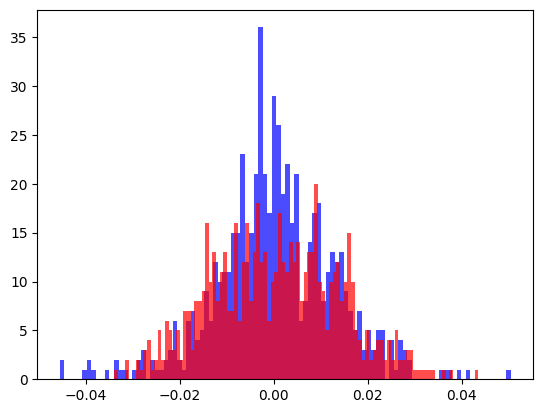

In [ ]:
gen, generator = bigan_var(ret_data_com)

plt.hist(ret_data[0], bins =100, color = 'blue', alpha = 0.7)
plt.hist(gen, bins =100, color = 'red', alpha = 0.7)
plt.show();

In [ ]:
def bigan_var(ret_data, generator):
    num_inputs = ret_data.shape[1]
    num_hidden = 100
    num_encoding = 10
    num_epochs = 10
    batch_size = 100

    discriminator = BidirectionalGenerativeAdversarialNetworkDiscriminator(
        num_hidden=num_hidden
    )
    encoder = BidirectionalGenerativeAdversarialNetworkEncoder(
        num_hidden=num_hidden, num_encoding=num_encoding
    )

    ds = (
        tf.data.Dataset.from_tensor_slices(tensors=ret_data)
        .shuffle(buffer_size=ret_data.shape[0] * 2, reshuffle_each_iteration=True)
        .batch(batch_size=batch_size, drop_remainder=False)
    )

    reconstruction_loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=False, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
    )
    optimizer_disc = tf.keras.optimizers.legacy.RMSprop(
        learning_rate=2e-4, decay=1e-8, clipvalue=1.0
    )
    optimizer_enc_gen = tf.keras.optimizers.legacy.RMSprop(
        learning_rate=4e-4, decay=1e-8, clipvalue=1.0
    )
    disc_loss_metric = tf.keras.metrics.Mean(name="train_disc_loss")
    enc_loss_metric = tf.keras.metrics.Mean(name="train_enc_loss")
    gen_loss_metric = tf.keras.metrics.Mean(name="train_gen_loss")

    num_sim = ret_data.shape[0]
    with tf.device(device_name="/CPU:0"):
        x_mean = [
            np.average(
                a=(
                    generator(
                        z=np.array(
                            object=[
                                np.random.uniform(low=ret_data.min()-0.01, high=ret_data.max()+0.01, size=(num_encoding))
                            ]
                        )
                    )[0]
                    #* std
                )
                #+ mean
            )
            for i in range(num_sim)
        ]

    return  np.percentile(a=x_mean, axis=0, q=1)

In [ ]:
w = 200

i = w
portf = ret_data_com.copy()
var_values = pd.DataFrame({'Date': [], 'VaR': []})
breakdowns  = pd.DataFrame({'Date': [], 'value': []})

while i <=ret_data_com.shape[0] - 1:
  print(i)
  var_values = pd.concat([var_values, pd.DataFrame({'Date': [portf[i:i+1].index.date[0]], 'VaR': [bigan_var(portf[i-w:i], generator)]})])
  i+=1

# var_values.to_csv('bigan_vals.csv')
# files.download('bigan_vals.csv')

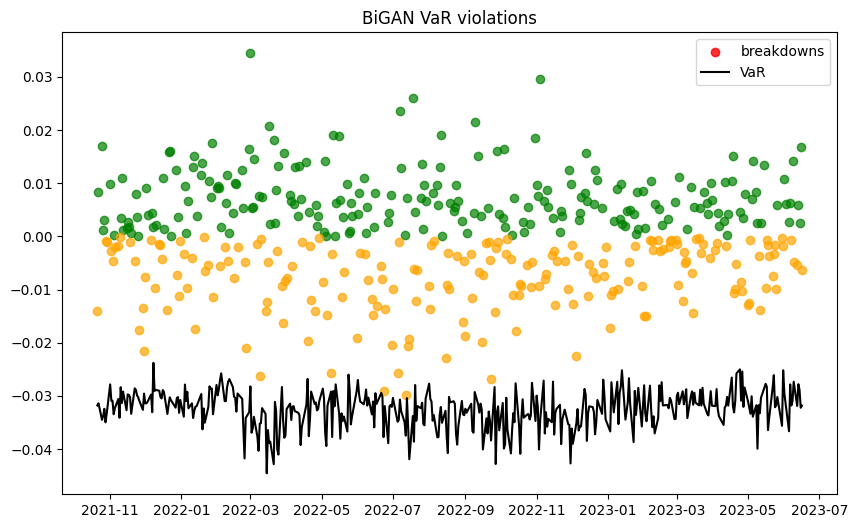

In [ ]:
portf= ret_data_com[200:]
fig, ax = plt.subplots(figsize=(10, 6))
pos = portf[portf.apply(lambda x: x >= 0)]
neg = portf[portf.apply(lambda x: x <  0)]

var_values['Date'] = pd.to_datetime(var_values['Date'])
var_df_com = var_values.merge(portf.reset_index(), on='Date')
var_df_com.columns = ['Date', 'VaR', 'Change']
var_df_com['VaR'] = var_df_com['VaR']
var_df_com['Violation'] = (var_df_com['Change'] < var_df_com['VaR'])
breakdowns = var_df_com[var_df_com['Violation'] == 1]

#breakdowns['VaR'] = breakdowns['VaR']- 0.005
#breakdowns = breakdowns[breakdowns['Change'] < breakdowns['VaR']]

plt.scatter(pos.index,pos, c = 'green', alpha = 0.7)
plt.scatter(neg.index,neg, c = 'orange', alpha = 0.7)
plt.scatter(breakdowns.Date, breakdowns.Change, c = 'red', alpha = 0.8,  label = 'breakdowns')
plt.plot(var_df_com.Date, var_df_com.VaR, label = 'VaR', c = 'black')
plt.legend()
plt.title("{} VaR violations".format('BiGAN'))
plt.show();

In [ ]:
from scipy.stats import chi2
def pof_test(var, target, alpha=0.998):
    exception = target < var
    t = len(target)
    m = exception.sum()
    nom = (1 - alpha)**m * alpha**(t-m)
    den = (1 - m/t)**(t - m) * (m / t)**m
    pof_test = -2 * np.log(nom / den)
    pvalue = 1 - chi2.cdf(pof_test, df=1)
    return pvalue

def if_test(var, target):
    exception = target < var
    pairs = [(exception[i], exception[i+1]) for i in range(len(exception) - 1)]
    pairs = np.array(pairs).astype('int')
    n00 = ((pairs[:, 0] == 0) & (pairs[:, 1] == 0)).sum()
    n01 = ((pairs[:, 0] == 0) & (pairs[:, 1] == 1)).sum()
    n10 = ((pairs[:, 0] == 1) & (pairs[:, 1] == 0)).sum()
    n11 = ((pairs[:, 0] == 1) & (pairs[:, 1] == 1)).sum()
    pi = (n01 + n11) / (n00 + n01 + n10 + n11)
    pi0 = n01 / (n00 + n01)
    pi1 = n11 / (n10 + n11)
    nom = (1 - pi)**(n00 + n10) * pi**(n01 + n11)
    den = (1 - pi0)**n00 * pi0**n01 * (1 - pi1)**n10 * pi1**n11
    if_test = -2 * np.log(nom / den)
    pvalue = 1 - chi2.cdf(if_test, df=1)
    return pvalue

def tests(df):
    print("%.2f" % pof_test(df['VaR'], df['Change']))
    print("%.2f" % if_test(df['VaR'], df['Change']))

In [ ]:
tests(var_df_com)

0.20
1.00


<ipython-input-28-2eebef31b1a0>:22: RuntimeWarning: invalid value encountered in long_scalars


In [ ]:
tests(var_df)

0.00
0.62


In [ ]:
def bigan_var(ret_data):
    num_inputs = ret_data.shape[1]
    num_hidden = 100
    num_encoding = 10
    num_epochs = 10
    batch_size = 100

    generator = BidirectionalGenerativeAdversarialNetworkGenerator(
        num_hidden=num_hidden, num_inputs=num_inputs
    )
    discriminator = BidirectionalGenerativeAdversarialNetworkDiscriminator(
        num_hidden=num_hidden
    )
    encoder = BidirectionalGenerativeAdversarialNetworkEncoder(
        num_hidden=num_hidden, num_encoding=num_encoding
    )

    ds = (
        tf.data.Dataset.from_tensor_slices(tensors=ret_data)
        .shuffle(buffer_size=ret_data.shape[0] * 2, reshuffle_each_iteration=True)
        .batch(batch_size=batch_size, drop_remainder=False)
    )

    reconstruction_loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=False, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
    )
    optimizer_disc = tf.keras.optimizers.legacy.RMSprop(
        learning_rate=2e-4, decay=1e-8, clipvalue=1.0
    )
    optimizer_enc_gen = tf.keras.optimizers.legacy.RMSprop(
        learning_rate=4e-4, decay=1e-8, clipvalue=1.0
    )
    disc_loss_metric = tf.keras.metrics.Mean(name="train_disc_loss")
    enc_loss_metric = tf.keras.metrics.Mean(name="train_enc_loss")
    gen_loss_metric = tf.keras.metrics.Mean(name="train_gen_loss")


    for epoch in range(num_epochs):
        disc_loss_metric.reset_states()
        enc_loss_metric.reset_states()
        gen_loss_metric.reset_states()

        for x in ds:
            train_step(
                x=x,
                real=np.ones(shape=(x.shape[0], 1)),
                z=np.random.uniform(low=-1.0, high=1.0, size=(x.shape[0], num_encoding)),
                fake=np.zeros(shape=(x.shape[0], 1)),
            )

        if ((epoch + 1) % 100) == 0:
            print("Epoch:", epoch + 1)
            print("Discriminator loss:", disc_loss_metric.result())
            print("Encoder loss:", enc_loss_metric.result())
            print("Generator loss:", gen_loss_metric.result())


    num_sim = ret_data.shape[0]
    with tf.device(device_name="/CPU:0"):
        x_mean = [
            np.average(
                a=(
                    generator(
                        z=np.array(
                            object=[
                                np.random.uniform(low=ret_data.min()-0.01, high=ret_data.max()+0.01, size=(num_encoding))
                            ]
                        )
                    )[0]
                    #* std
                )
                #+ mean
            )
            for i in range(num_sim)
        ]

    return np.percentile(a=x_mean, axis=0, q=1)

In [ ]:
w = 200

i = w
portf = ret_data_com.copy()
var_values_gen = pd.DataFrame({'Date': [], 'VaR': []})

while i <=ret_data_com.shape[0] - 1:
  print(i)
  var_values_gen = pd.concat([var_values_gen, pd.DataFrame({'Date': [portf[i:i+1].index.date[0]], 'VaR': [bigan_var(portf[i-w:i])]})])
  i+=1

254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503


In [ ]:
var_values_gen.head()

,Date,VaR
0,2021-10-21,-3.263843
0,2021-10-22,-2.100189
0,2021-10-25,-2.803942
0,2021-10-26,-2.384378
0,2021-10-27,-2.759588


In [ ]:
var_df_gen

In [ ]:
portf= ret_data_com[200:]
fig, ax = plt.subplots(figsize=(10, 6))
pos = portf[portf.apply(lambda x: x >= 0)]
neg = portf[portf.apply(lambda x: x <  0)]

var_values_gen['Date'] = pd.to_datetime(var_values_gen['Date'])
#var_values_gen['VaR'] = var_values_gen['VaR']/100

var_df_gen = var_values_gen.merge(portf.reset_index(), on='Date')
var_df_gen.columns = ['Date', 'VaR', 'Change']
var_df_gen['VaR'] = var_df_gen['VaR']
var_df_gen['Violation'] = (var_df_gen['Change'] < var_df_gen['VaR'])
breakdowns = var_df_gen[var_df_gen['Violation'] == 1]

#breakdowns['VaR'] = breakdowns['VaR']- 0.005
#breakdowns = breakdowns[breakdowns['Change'] < breakdowns['VaR']]

plt.scatter(pos.index,pos, c = 'green', alpha = 0.7)
plt.scatter(neg.index,neg, c = 'orange', alpha = 0.7)
plt.scatter(breakdowns.Date, breakdowns.Change, c = 'red', alpha = 0.8,  label = 'breakdowns')
plt.plot(var_df_com.Date, var_df_com.VaR, label = 'VaR', c = 'black')
plt.legend()
plt.title("{} VaR violations".format('BiGAN'))
plt.show();

In [ ]:
tests(var_df_gen)

In [ ]:
w = 200

i = w
portf = ret_data.copy()
var_values_gen_st = pd.DataFrame({'Date': [], 'VaR': []})

while i <=ret_data_com.shape[0] - 1:
  print(i)
  var_values_gen_st = pd.concat([var_values_gen_st, pd.DataFrame({'Date': [portf[i:i+1].index.date[0]], 'VaR': [bigan_var(portf[i-w:i])]})])
  i+=1

In [ ]:
w = 200

i = w
portf = ret_data.copy()
var_values_gen_st = pd.DataFrame({'Date': [], 'VaR': []})

while i <=ret_data_com.shape[0] - 1:
  print(i)
  var_values_gen_st = pd.concat([var_values_gen_st, pd.DataFrame({'Date': [portf[i:i+1].index.date[0]], 'VaR': [bigan_var(portf[i-w:i])]})])
  i+=1

In [ ]:
path = '/content/drive/My Drive/var_values_gen.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  var_values_gen.to_csv(f)

# old

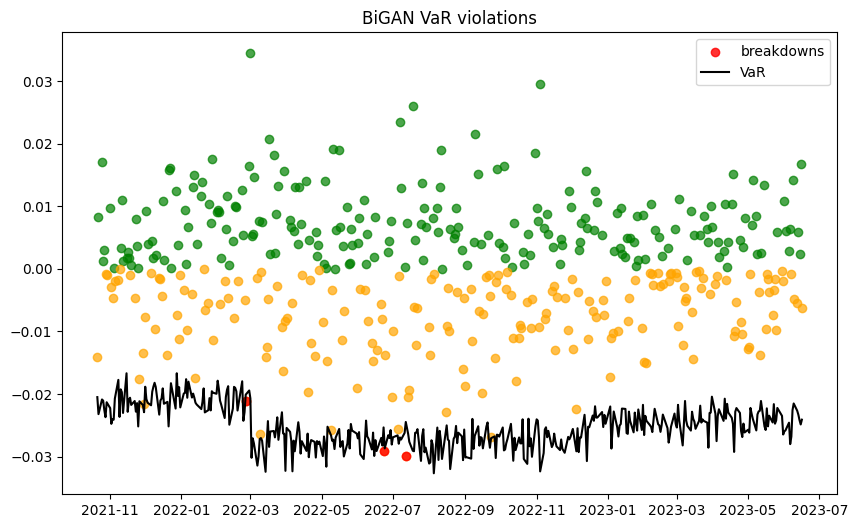

In [ ]:
portf= ret_data_com[200:]
fig, ax = plt.subplots(figsize=(10, 6))
pos = portf[portf.apply(lambda x: x >= 0)]
neg = portf[portf.apply(lambda x: x <  0)]

var_values['Date'] = pd.to_datetime(var_values['Date'])
var_df = var_values.merge(portf.reset_index(), on='Date')
var_df.columns = ['Date', 'VaR', 'Change']
var_df['VaR'] = var_df['VaR']- 0.0057
var_df['Violation'] = (var_df['Change'] < var_df['VaR'])
breakdowns = var_df[var_df['Violation'] == 1]

#breakdowns['VaR'] = breakdowns['VaR']- 0.005
#breakdowns = breakdowns[breakdowns['Change'] < breakdowns['VaR']]

plt.scatter(pos.index,pos, c = 'green', alpha = 0.7)
plt.scatter(neg.index,neg, c = 'orange', alpha = 0.7)
plt.scatter(breakdowns.Date, breakdowns.Change, c = 'red', alpha = 0.8,  label = 'breakdowns')
plt.plot(var_df.Date, var_df.VaR, label = 'VaR', c = 'black')
plt.legend()
plt.title("{} VaR violations".format('BiGAN'))
plt.show();

In [ ]:
from scipy.stats import chi2
def pof_test(var, target, alpha=0.99):
    exception = target < var
    t = len(target)
    m = exception.sum()
    nom = (1 - alpha)**m * alpha**(t-m)
    den = (1 - m/t)**(t - m) * (m / t)**m
    pof_test = -2 * np.log(nom / den)
    pvalue = 1 - chi2.cdf(pof_test, df=1)
    return pvalue

def if_test(var, target):
    exception = target < var
    pairs = [(exception[i], exception[i+1]) for i in range(len(exception) - 1)]
    pairs = np.array(pairs).astype('int')
    n00 = ((pairs[:, 0] == 0) & (pairs[:, 1] == 0)).sum()
    n01 = ((pairs[:, 0] == 0) & (pairs[:, 1] == 1)).sum()
    n10 = ((pairs[:, 0] == 1) & (pairs[:, 1] == 0)).sum()
    n11 = ((pairs[:, 0] == 1) & (pairs[:, 1] == 1)).sum()
    pi = (n01 + n11) / (n00 + n01 + n10 + n11)
    pi0 = n01 / (n00 + n01)
    pi1 = n11 / (n10 + n11)
    nom = (1 - pi)**(n00 + n10) * pi**(n01 + n11)
    den = (1 - pi0)**n00 * pi0**n01 * (1 - pi1)**n10 * pi1**n11
    if_test = -2 * np.log(nom / den)
    pvalue = 1 - chi2.cdf(if_test, df=1)
    return pvalue

In [ ]:
pof_test(var_df['VaR'], var_df['Change'], alpha=0.99)

0.5412825850735077

In [ ]:
if_test(var_df['VaR'], var_df['Change'])

0.8348266168185587

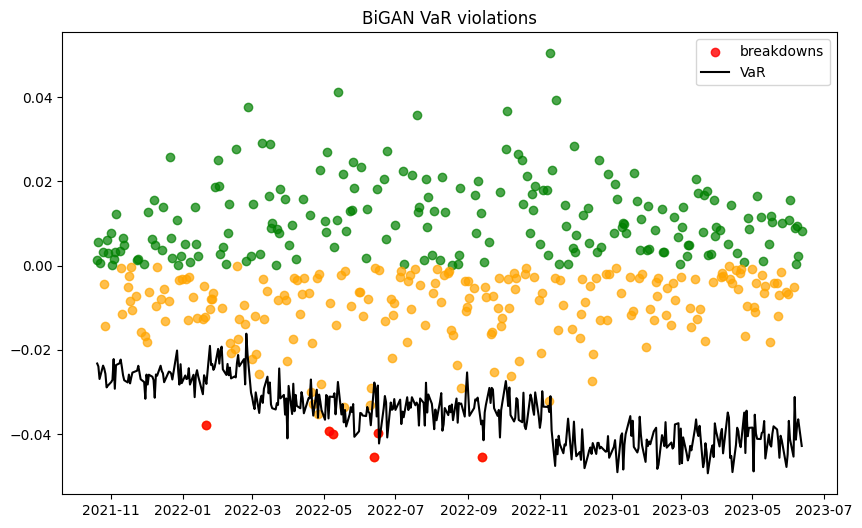

In [ ]:
portf= ret_data[200:]
fig, ax = plt.subplots(figsize=(10, 6))
pos = portf[portf.apply(lambda x: x >= 0)]
neg = portf[portf.apply(lambda x: x <  0)]

var_values['Date'] = pd.to_datetime(var_values['Date'])
var_df = var_values.merge(portf.reset_index(), on='Date')
var_df.columns = ['Date', 'VaR', 'Change']
var_df['Violation'] = (var_df['Change'] < var_df['VaR'])
#breakdowns = var_df[var_df['Violation'] == 1]

#breakdowns['VaR'] = breakdowns['VaR']- 0.005
#breakdowns = breakdowns[breakdowns['Change'] < breakdowns['VaR']]

plt.scatter(pos.index,pos, c = 'green', alpha = 0.7)
plt.scatter(neg.index,neg, c = 'orange', alpha = 0.7)
plt.scatter(breakdowns.Date, breakdowns.Change, c = 'red', alpha = 0.8,  label = 'breakdowns')
plt.plot(var_values.Date, var_values.VaR, label = 'VaR', c = 'black')
plt.legend()
plt.title("{} VaR violations".format('BiGAN'))
plt.show();

In [ ]:
w = 200

i = w
portf = ret_data.copy()
var_values = pd.DataFrame({'Date': [], 'VaR': []})
breakdowns  = pd.DataFrame({'Date': [], 'value': []})

while i <=300:
    var_values = pd.concat([var_values, pd.DataFrame({'Date': [portf[i:i+1].index.date[0]], 'VaR': [bigan_var(portf[i-w:i])]})])
    i+=1

# var_values.to_csv('deepvar_vals.csv')
# files.download('deepvar_vals.csv')

TypeError: ignored

In [ ]:
var_values_200 = var_values.copy()

In [ ]:
w = 200
i = 301

while i <=400:
    var_values = pd.concat([var_values, pd.DataFrame({'Date': [portf[i:i+1].index.date[0]], 'VaR': [bigan_var(portf[i-w:i])]})])
    i+=1

In [ ]:
var_values.shape

In [ ]:
portf= ret_data[200:]
fig, ax = plt.subplots(figsize=(10, 6))
pos = portf[portf.apply(lambda x: x >= 0)]
neg = portf[portf.apply(lambda x: x <  0)]

var_values['Date'] = pd.to_datetime(var_values['Date'])
var_df = var_values.merge(portf.reset_index(), on='Date')
var_df.columns = ['Date', 'VaR', 'Change']
var_df['Violation'] = (var_df['Change'] < var_df['VaR'])

breakdowns = var_df[var_df['Violation'] == 1]


plt.scatter(pos.index,pos, c = 'green', alpha = 0.7)
plt.scatter(neg.index,neg, c = 'orange', alpha = 0.7)
plt.scatter(breakdowns.Date, breakdowns.Change, c = 'red', alpha = 0.8,  label = 'breakdowns')
plt.plot(var_values.Date, var_values.VaR, label = 'VaR', c = 'black')
plt.legend()
plt.title("{} VaR violations".format('BiGAN'))
plt.show();

In [ ]:
100 * np.percentile(a=x_mean, axis=0, q=1)

In [ ]:
num_sim = 1000
with tf.device(device_name="/CPU:0"):
    x_mean = [
        np.average(
            a=(
                generator(
                    z=np.array(
                        object=[
                            np.random.uniform(low=-1.0, high=1.0, size=(num_encoding))
                        ]
                    )
                )[0]
                * std
            )
            + mean
        )
        for i in range(num_sim)
    ]

act_mean = [
    np.average(a=(ret_data.iloc[i] * std) + mean) for i in range(ret_data.shape[0])
]

plotnine.options.figure_size = (12, 9)
plot = (
    plotnine.ggplot(
        mapping=pd.melt(
            frame=pd.concat(
                objs=[
                    pd.DataFrame(
                        data=x_mean, columns=["BiGAN Portfolio Returns Distribution"]
                    ),
                    pd.DataFrame(
                        data=act_mean, columns=["Actual Portfolio Returns Distribution"]
                    ),
                ],
                axis=1,
            ).reset_index(drop=True)
        ).dropna(axis="index")
    )
    + plotnine.geom_density(
        mapping=plotnine.aes(
            x="value",
            fill="factor(variable)",
        ),
        alpha=0.5,
        color="black",
    )
    + plotnine.geom_point(
        mapping=plotnine.aes(x="value", y=0, fill="factor(variable)"),
        alpha=0.5,
        color="black",
    )
    + plotnine.xlab(xlab="Portfolio returns")
    + plotnine.ylab(ylab="Density")
    + plotnine.ggtitle(
        title="Trained Bidirectional Generative Adversarial Network (BiGAN) Portfolio Returns"
    )
    + plotnine.theme_matplotlib()
)
plot
#plot.save(filename="trained_bigan_sampler.png")
print(
    "The VaR at 1% estimate given by the BiGAN: {}%".format(
        100 * np.percentile(a=x_mean, axis=0, q=1)
    )
)

In [ ]:
from scipy.stats import chi2
def pof_test(var, target, alpha=0.998):
    exception = target < var
    t = len(target)
    m = exception.sum()
    nom = (1 - alpha)**m * alpha**(t-m)
    den = (1 - m/t)**(t - m) * (m / t)**m
    pof_test = -2 * np.log(nom / den)
    pvalue = 1 - chi2.cdf(pof_test, df=1)
    return pvalue

def if_test(var, target):
    exception = target < var
    pairs = [(exception[i], exception[i+1]) for i in range(len(exception) - 1)]
    pairs = np.array(pairs).astype('int')
    n00 = ((pairs[:, 0] == 0) & (pairs[:, 1] == 0)).sum()
    n01 = ((pairs[:, 0] == 0) & (pairs[:, 1] == 1)).sum()
    n10 = ((pairs[:, 0] == 1) & (pairs[:, 1] == 0)).sum()
    n11 = ((pairs[:, 0] == 1) & (pairs[:, 1] == 1)).sum()
    pi = (n01 + n11) / (n00 + n01 + n10 + n11)
    pi0 = n01 / (n00 + n01)
    pi1 = n11 / (n10 + n11)
    nom = (1 - pi)**(n00 + n10) * pi**(n01 + n11)
    den = (1 - pi0)**n00 * pi0**n01 * (1 - pi1)**n10 * pi1**n11
    if_test = -2 * np.log(nom / den)
    pvalue = 1 - chi2.cdf(if_test, df=1)
    return pvalue

def tests(df):
    print("%.2f" % pof_test(df['VaR'], df['Change']))
    print("%.2f" % if_test(df['VaR'], df['Change']))